# Decoding Responsivity
**Can we predict whether a stimulus will be detected or not based on neuron's responsivity ?**

Célien Vandromme
18/04/2024

---

# Modules & data import

---

In [115]:
import numpy as np
import pandas as pd
import percephone.core.recording as pc
import os
import matplotlib
import percephone.plts.stats as ppt
import matplotlib.pyplot as plt
from multiprocessing import Pool, cpu_count, pool
import warnings
import seaborn as sns

plt.rcParams['font.size'] = 10
plt.rcParams['axes.linewidth'] = 2
plt.switch_backend("Qt5Agg")
matplotlib.use("Qt5Agg")
%matplotlib inline
warnings.filterwarnings('ignore')
fontsize = 30

In [2]:
directory = "C:/Users/cvandromme/Desktop/Data/"
roi_info = pd.read_excel("C:/Users/cvandromme/Desktop/FmKO_ROIs&inhibitory.xlsx")
files = os.listdir(directory)
files_ = [file for file in files if file.endswith("synchro")]

In [3]:
def opening_rec(fil,i):
    rec = pc.RecordingAmplDet(directory + fil + "/", 0, fil, roi_info)
    return rec

In [4]:
workers = cpu_count()
pool = pool.ThreadPool(processes=workers)
async_results = [pool.apply_async(opening_rec, args=(file,i)) for i,file in enumerate(files_)]
recs = {ar.get().filename: ar.get() for ar in async_results}

Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.
Behavioural information already incorporated in the analog.


# Instantaneous Responsivity

---

In [36]:
def group_exc_inh(rec, parameter, label=False, invert_inh=False):
    exc = rec.matrices["EXC"][parameter]
    inh = rec.matrices["INH"][parameter]
    
    if invert_inh:
        inh = -inh
        
    if label:
        exc_col = np.ones(exc.shape[0])
        inh_col = np.zeros(inh.shape[0])
    
        exc = np.column_stack((exc_col, exc))
        inh = np.column_stack((inh_col, inh))
        
    return np.row_stack((exc, inh))

In [81]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, train_test_split
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/course-content/main/nma.mplstyle")

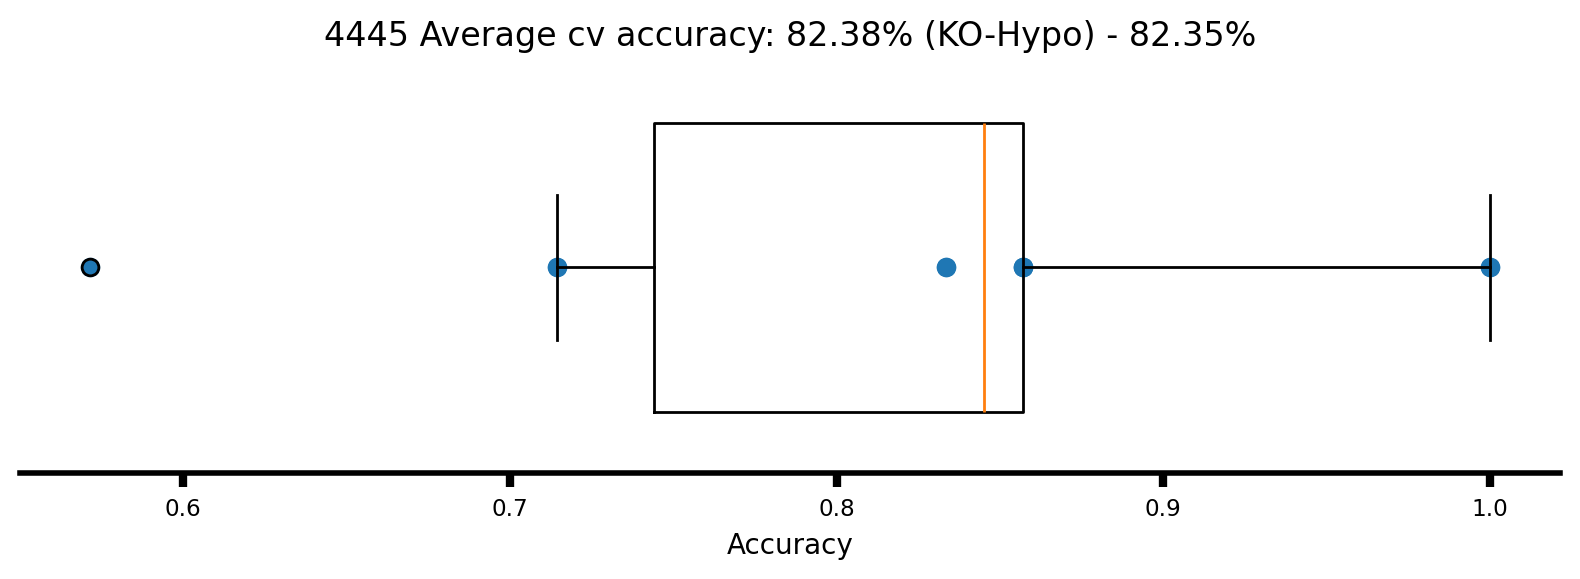

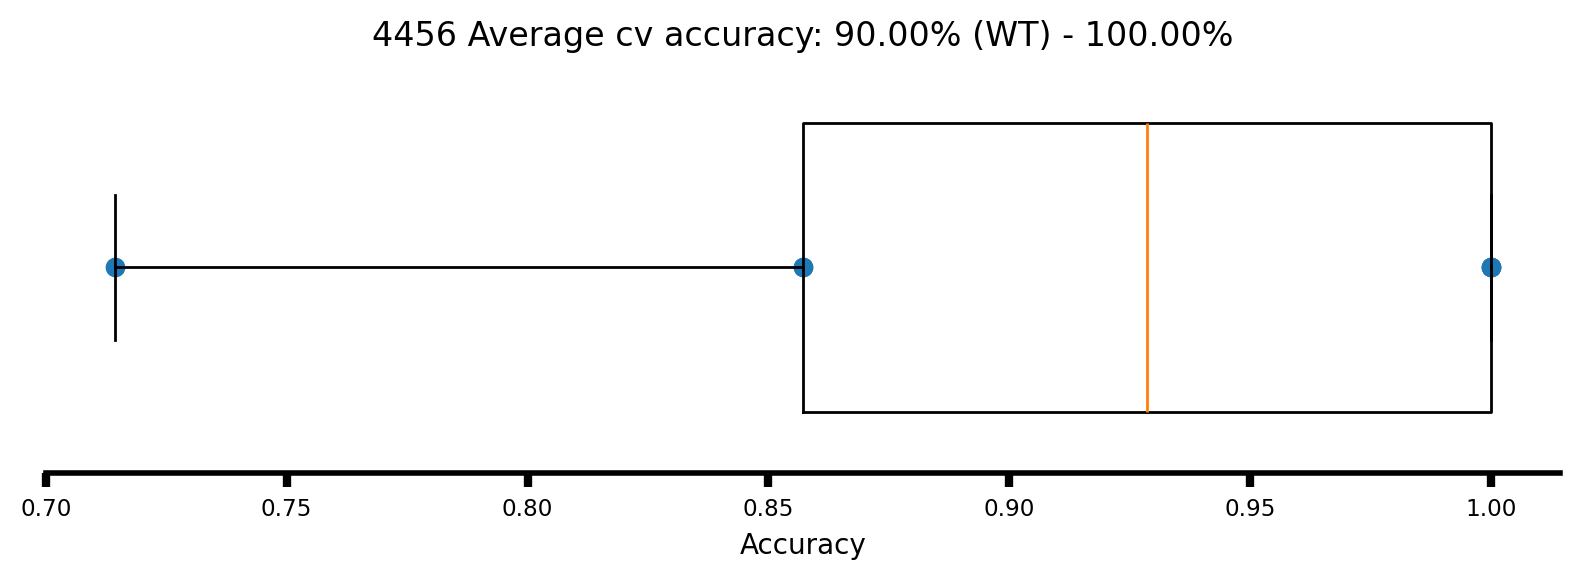

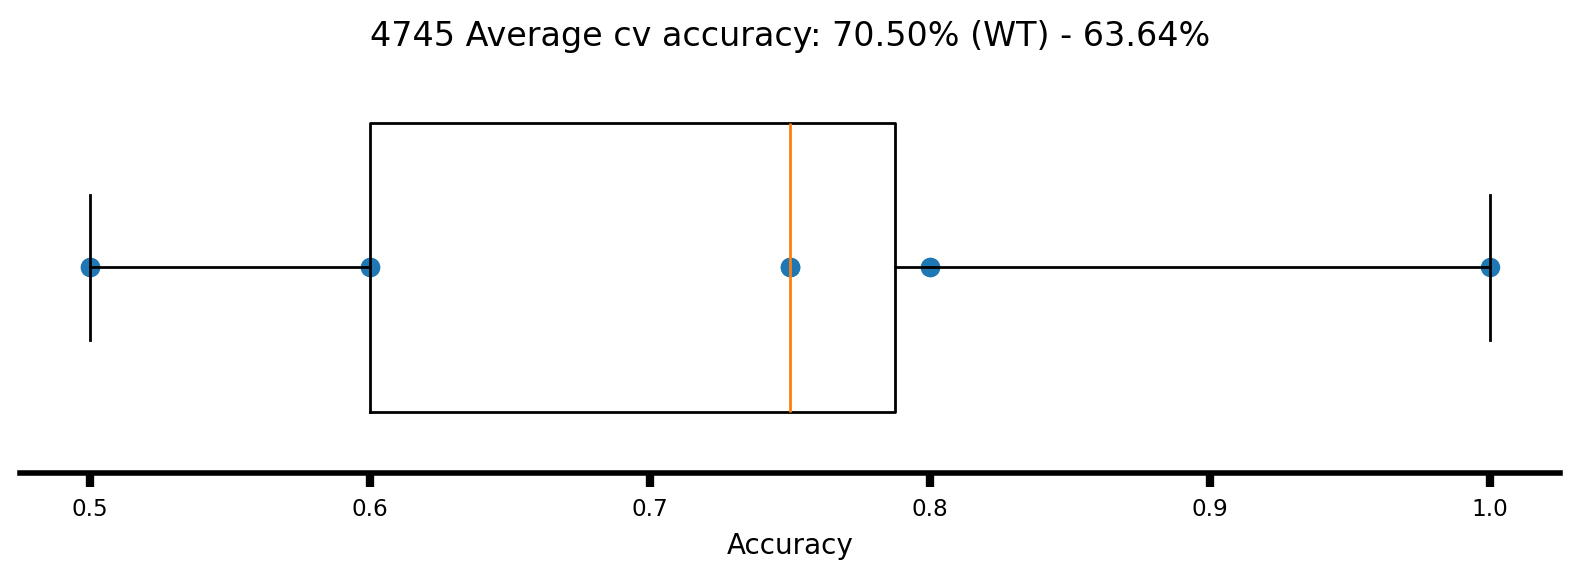

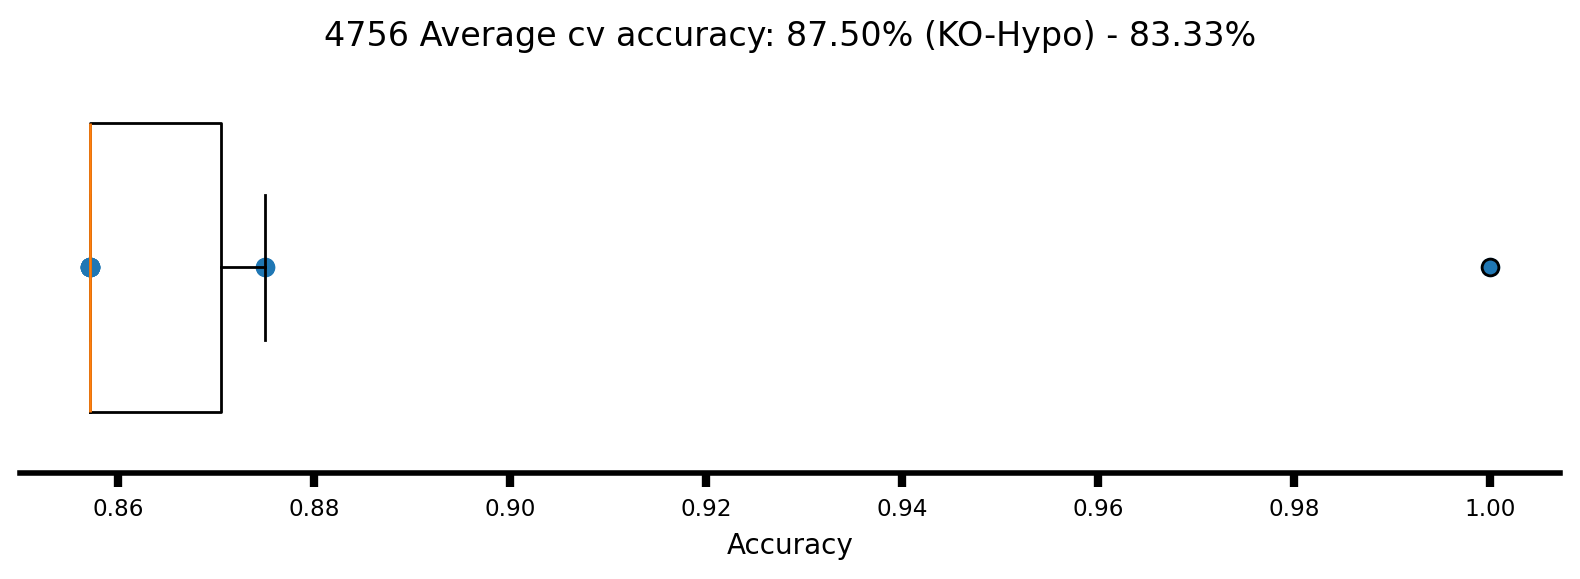

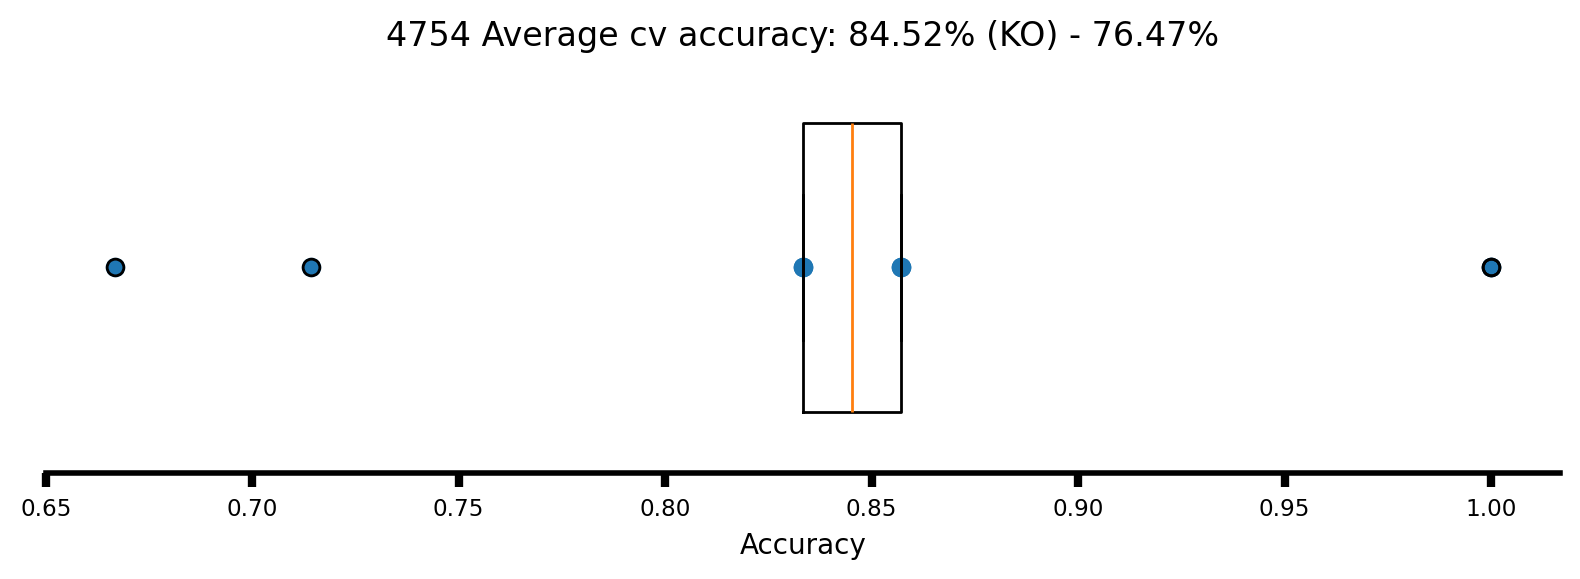

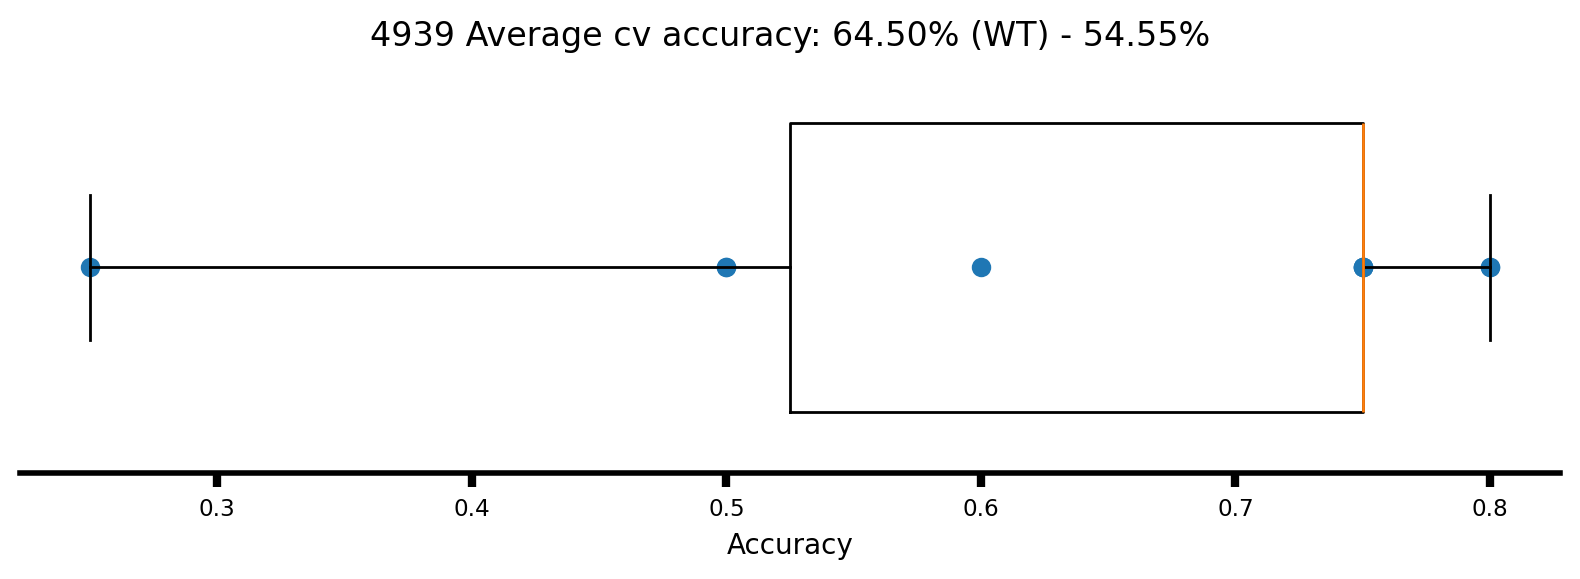

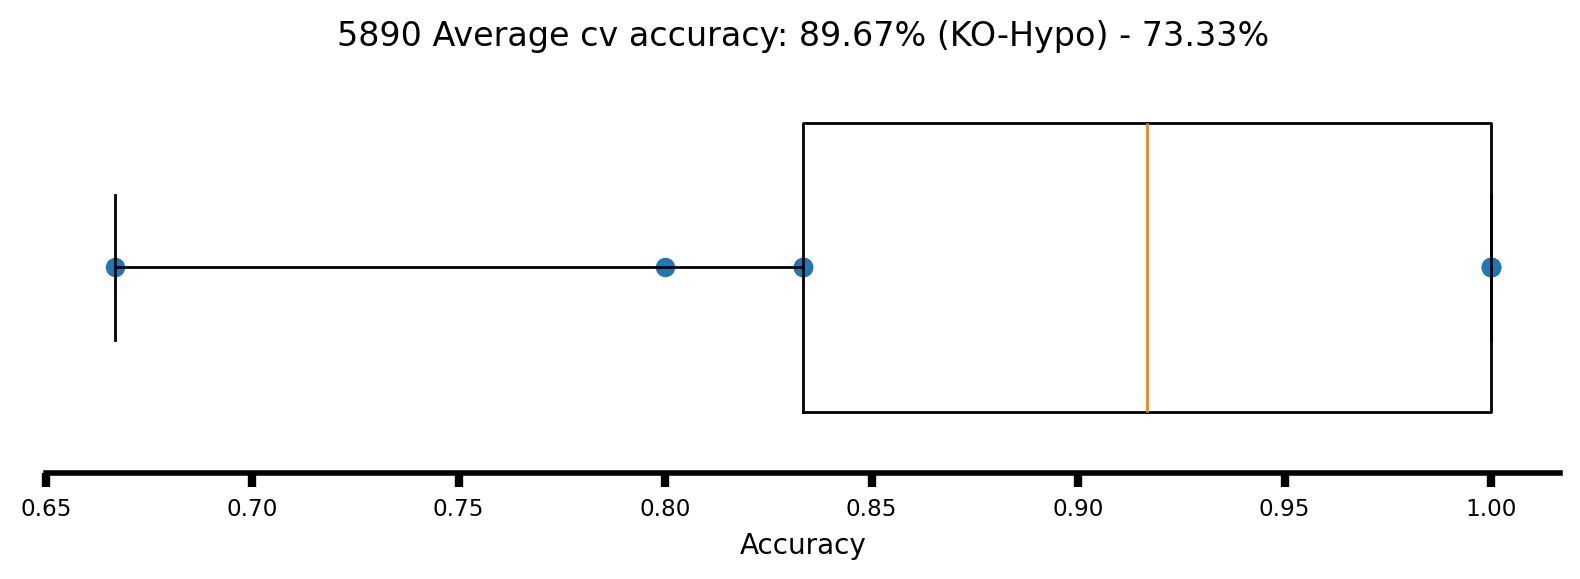

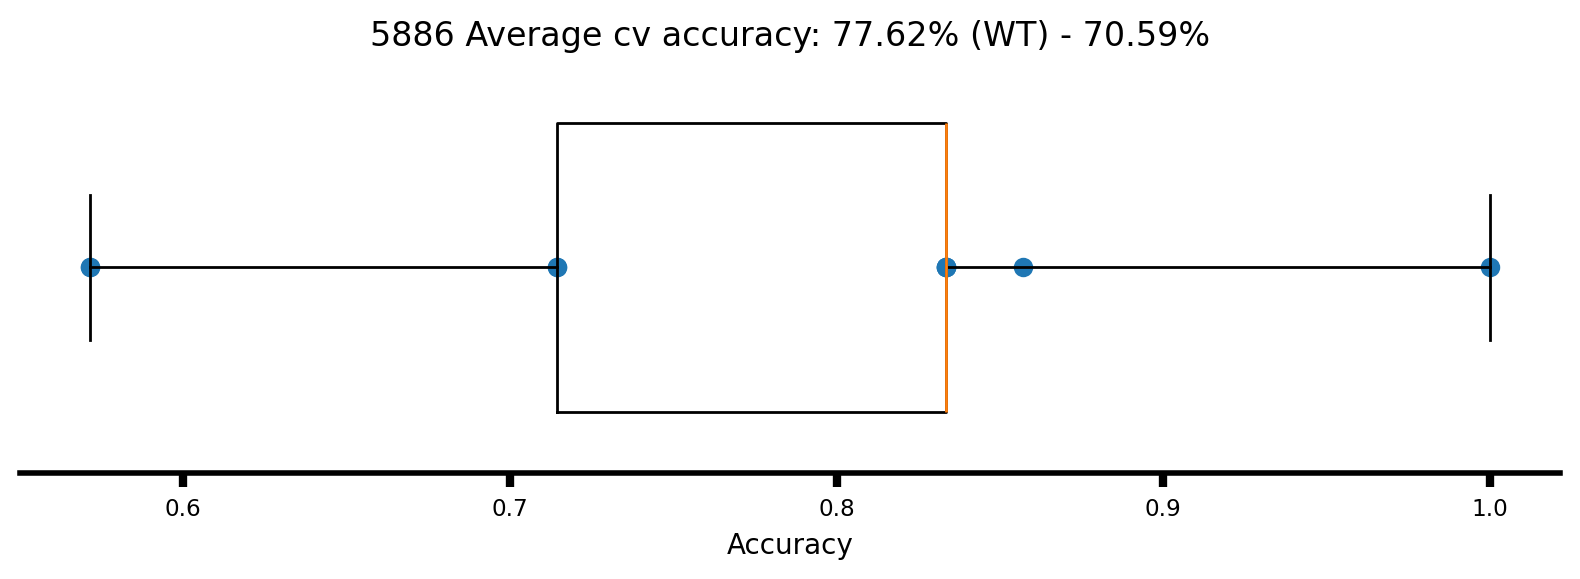

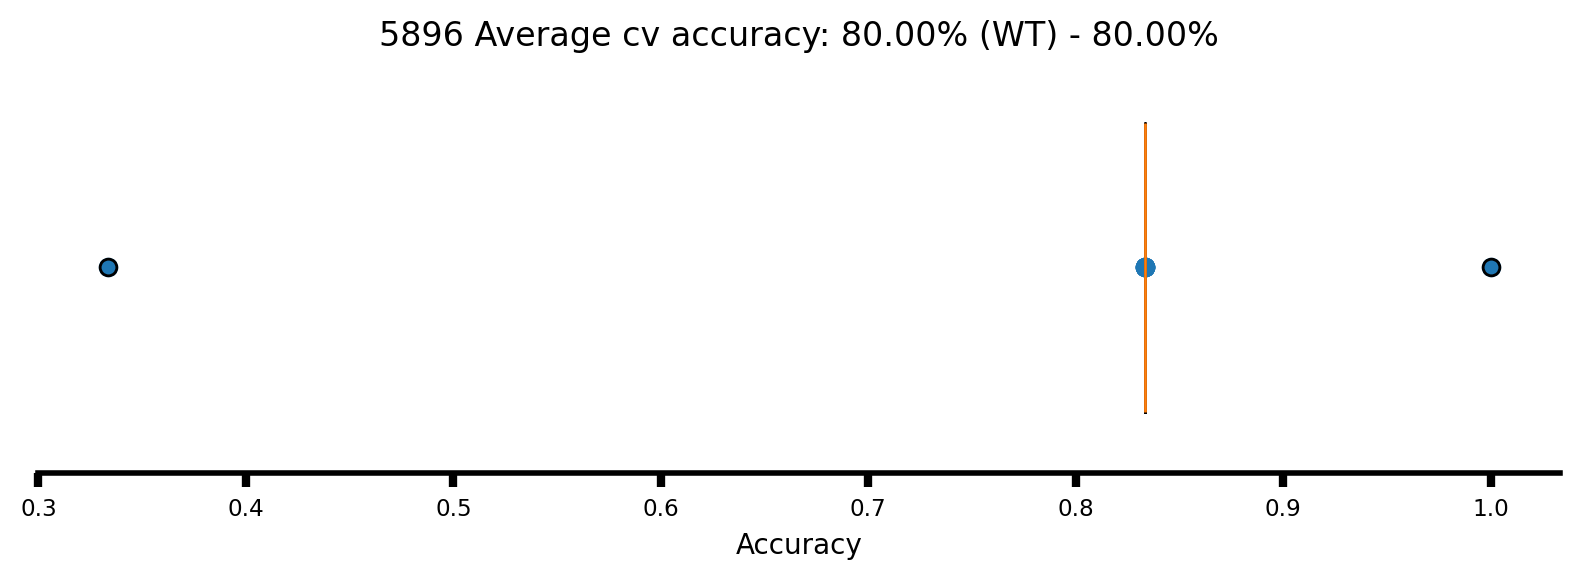

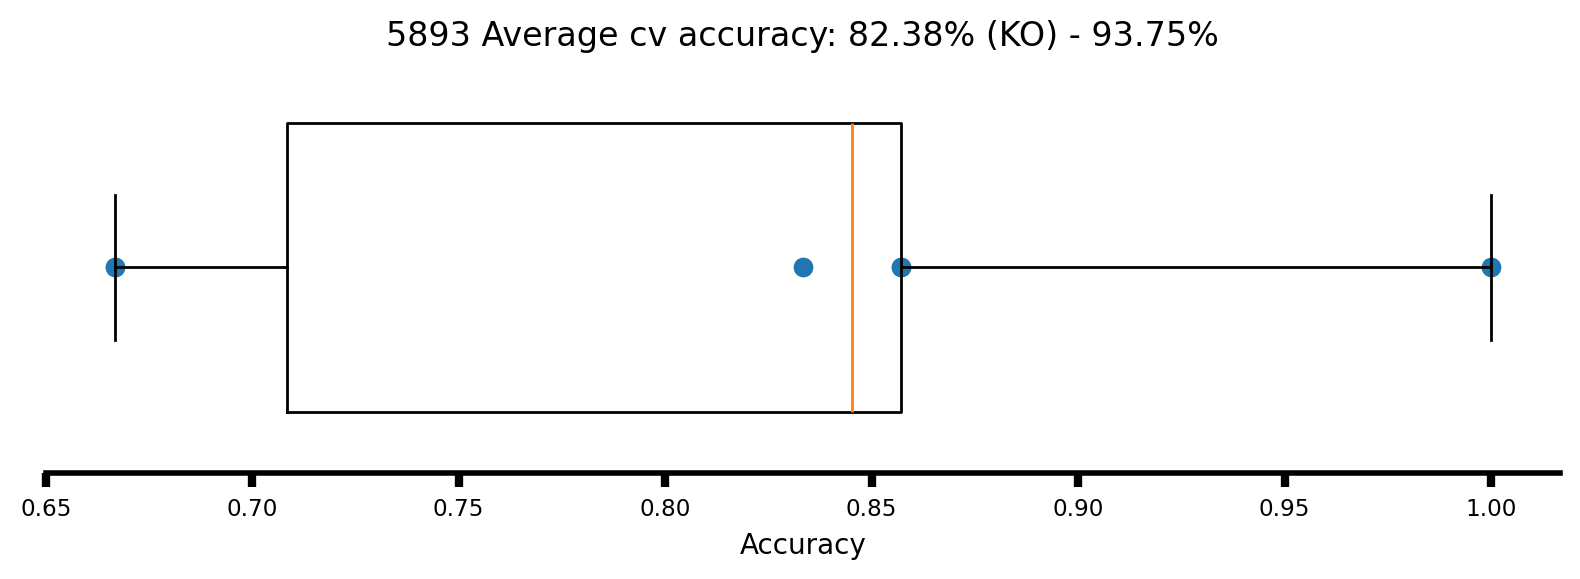

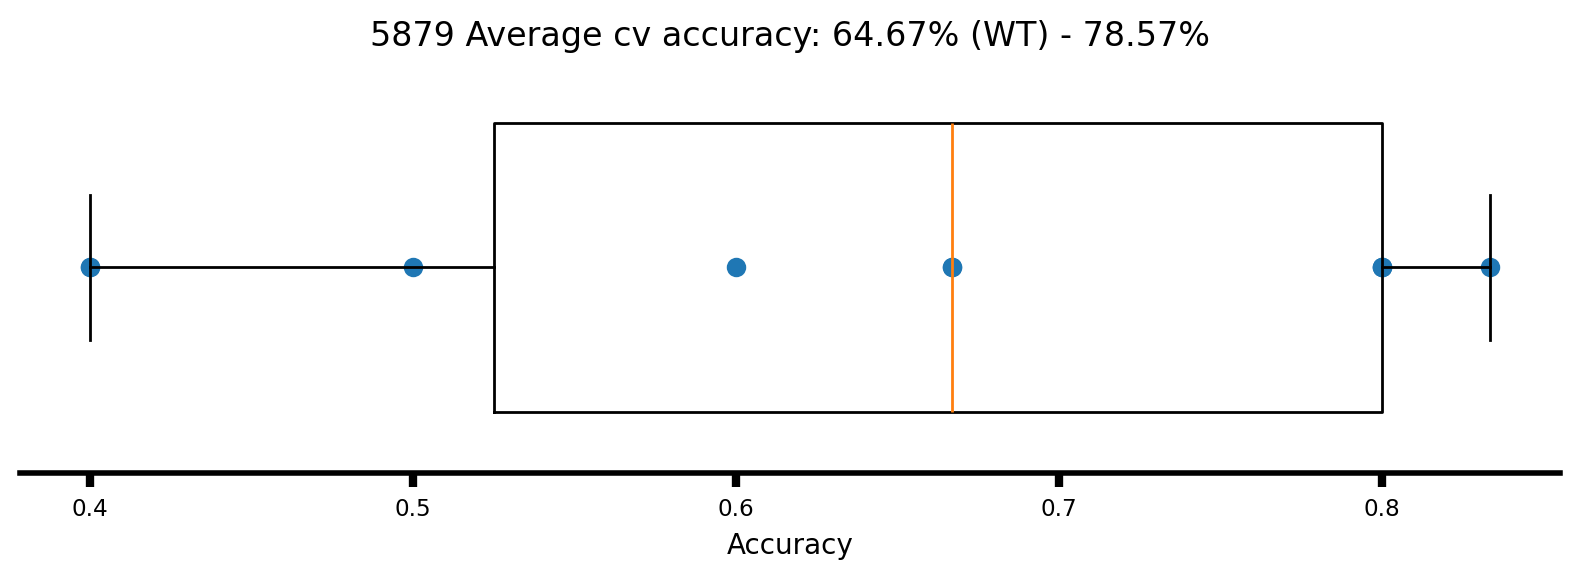

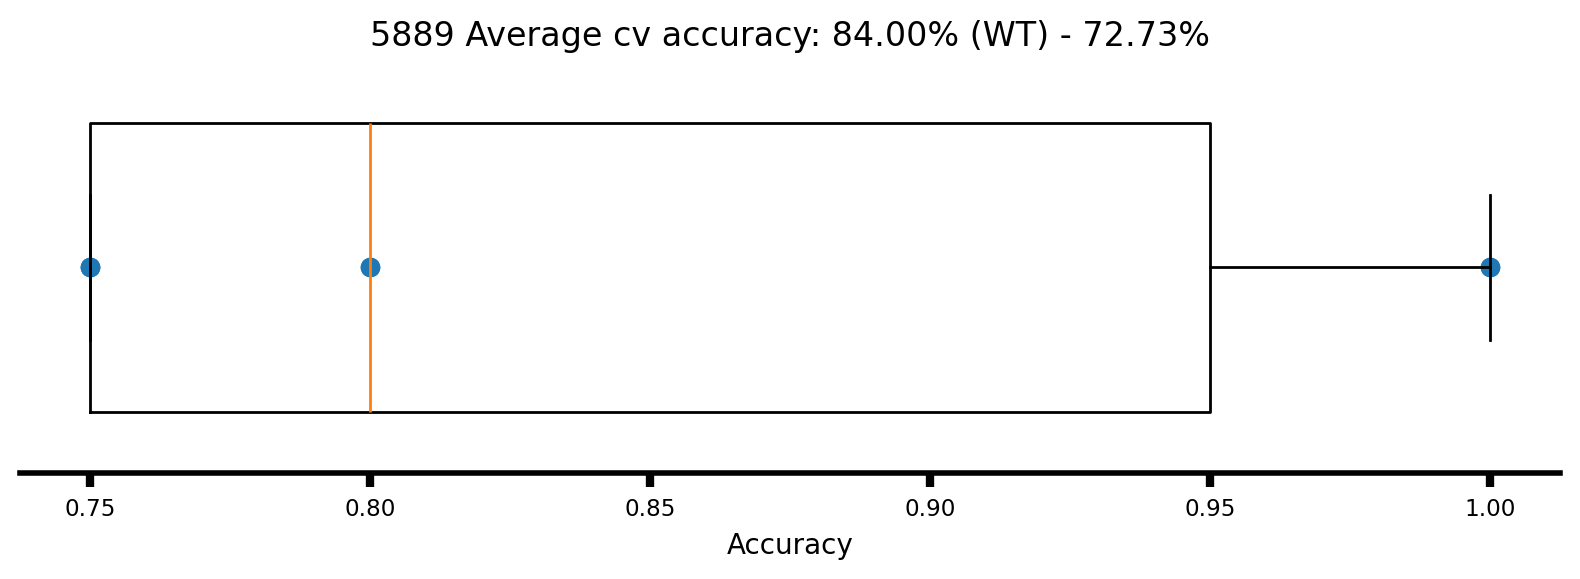

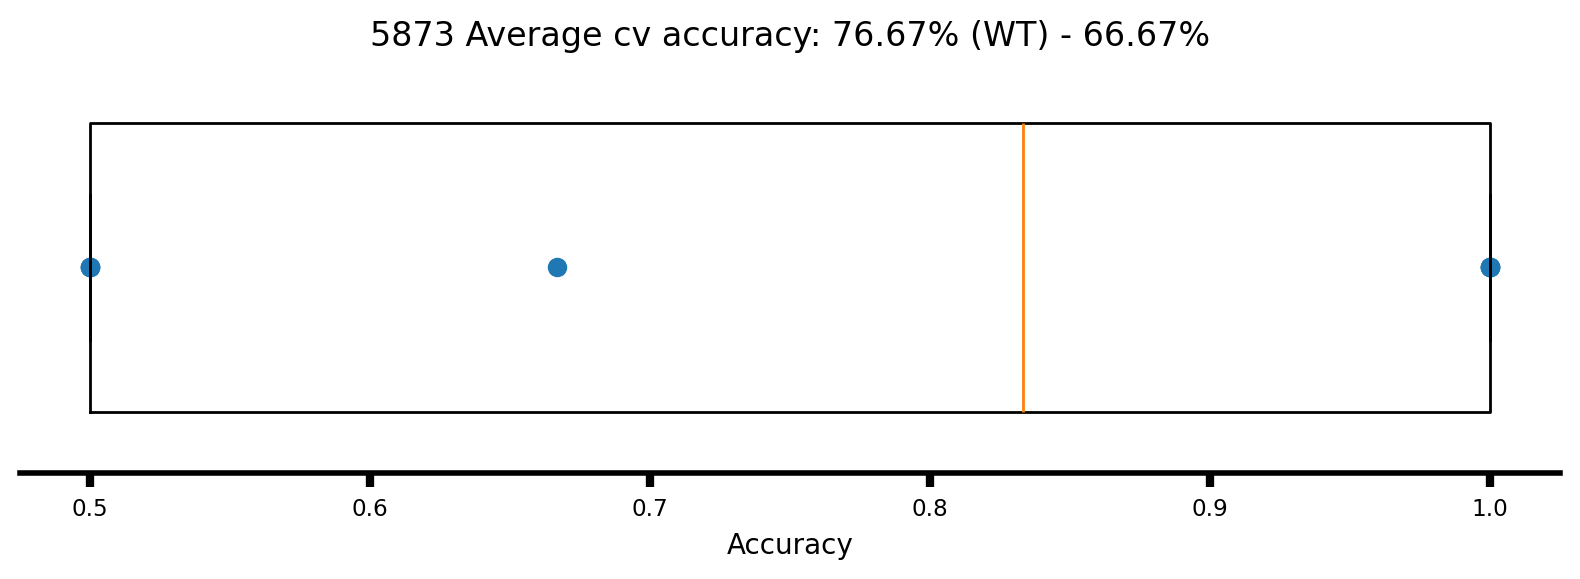

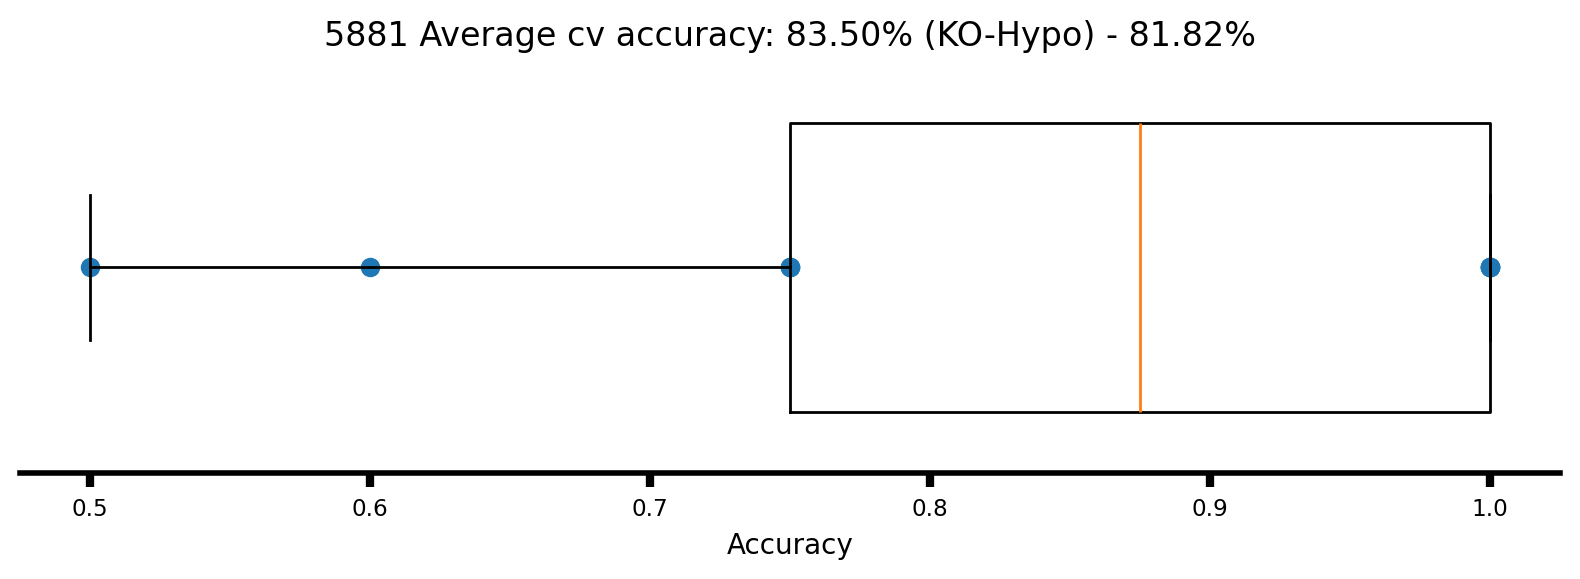

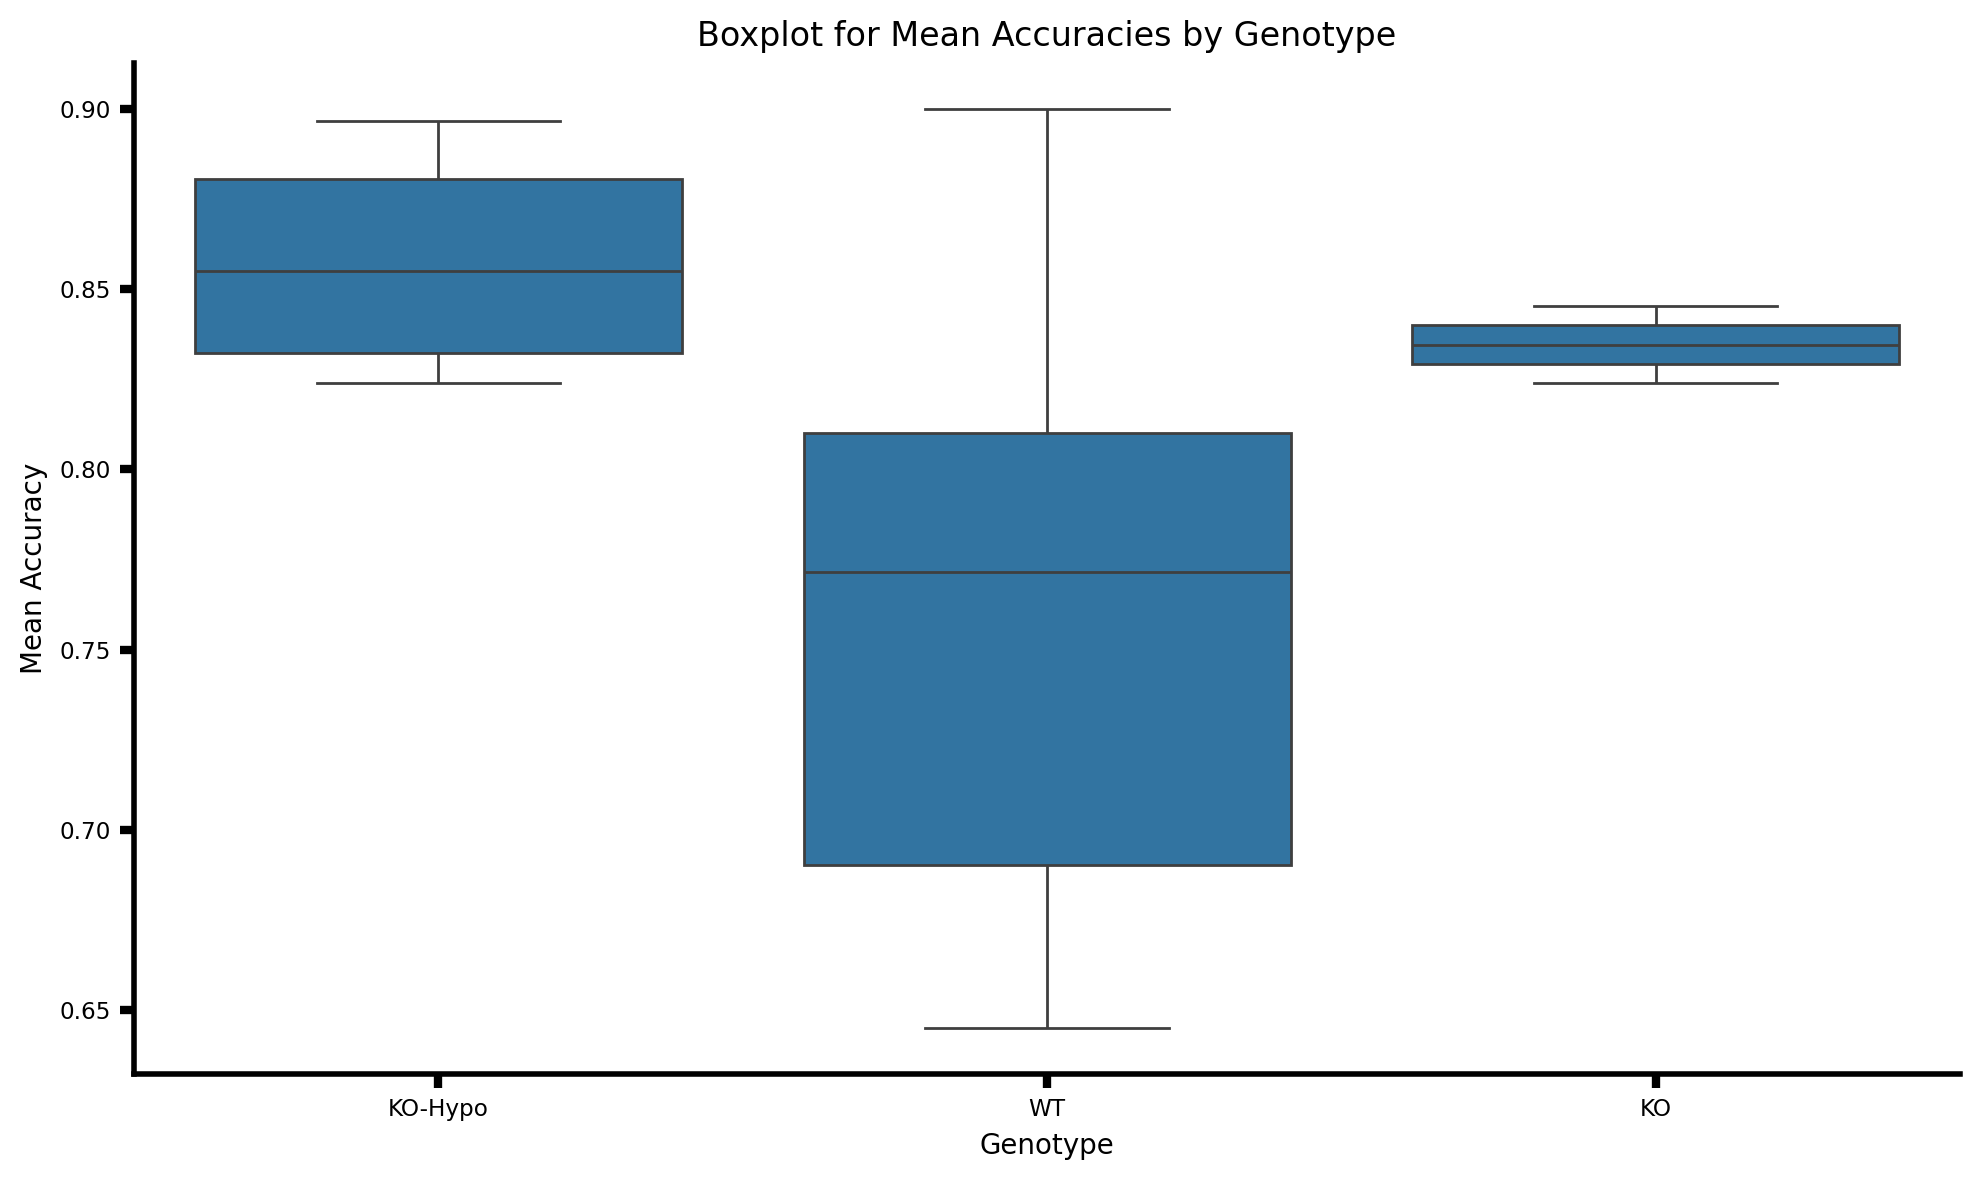

In [123]:
mean_accuracies = []
genotype_list = []

for rec in recs.values():
    # Defining X and other parameters
    # X = rec.matrices["EXC"]["Responsivity"].T
    X = group_exc_inh(rec, "Responsivity", invert_inh=True).T
    y = rec.detected_stim
    cv = 10
    
    # Splitting between train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8)
    model = LogisticRegression(penalty="l2")
    model.fit(X_train, y_train)
    
    # Cross-validation
    accuracies = cross_val_score(model, X_train, y_train, cv=cv)
    mean_accuracies.append(accuracies.mean())
    genotype_list.append(rec.genotype)
    
    # Accuracy on test data
    y_pred = model.predict(X_test)
    test_accuracy = (y_test == y_pred).sum() / len(y_test)
    
    # Boxplot
    f, ax = plt.subplots(figsize=(8, 3))
    ax.boxplot(accuracies, vert=False, widths=.7)
    ax.scatter(accuracies, np.ones(cv))
    ax.set(
      xlabel="Accuracy",
      yticks=[],
      title=f"{rec.filename} Average cv accuracy: {accuracies.mean():.2%} ({rec.genotype}) - {test_accuracy:.2%}"
    )
    ax.spines["left"].set_visible(False)
    plt.show()

df = pd.DataFrame({
    'genotype': genotype_list,
    'mean_accuracy': mean_accuracies
})

# Generate boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(x='genotype', y='mean_accuracy', data=df)
plt.title('Boxplot for Mean Accuracies by Genotype')
plt.xlabel('Genotype')
plt.ylabel('Mean Accuracy')
plt.show()